# 05_blob_feature.ipynb
### Create feature database of ocetrac blob features 


In [33]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops 
from dask_image.ndmeasure import label as label_dask
from skimage.measure import label as label_np
from datetime import date


#### Import Ocetrac labels and SST data


In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ocetrac_notrend.nc',
        '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ocetrac_labels              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  standardized SST anomalies above positive extreme threshold
    threshold:    0.9
    data:         preprocessed monthly averaged OISST v2.1

In [3]:
labels = ds.ocetrac_labels
num_events = labels.attrs['final objects tracked']
print(f"There are {num_events} total events tracked.")

There are 770 total events tracked.



TODO:

1. Look at distributions of events with different ENSO indices
   - accumulated area over the entire event
   - duration
   - number of events with footprints within the tropics +/- 10º Indian and Pacific only



2. Cluster trajectoreis of objects 
   - Find trajectories based on the centroid with the largest object


#### Event Database

- ID
- date
    - initial time (mm-yy)
    - final time (mm-yy)
- duration
- coordinates (lat,lon)
- centroid(s) (lat, lon)
- *number of centroids*
- *maximum distance between centroids*
- mean intensity
- maximum intensity
- minimum intensity
- cumulative intensity
- area
- *Nino index*



In [321]:
def get_labels(binary_images):
    '''label binary images at each time step using apply_ufunc'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def get_centroids(sub_labels):
    '''use skimage regionprops to find the centroids of objects assigned to each MHW label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

def get_intensity_area(event, ssta, mhw):
    '''mask SSTA using coordinate pairs to find event intensities'''
    event_ssta = ssta.where(event>0, drop=True)        
    mhw['intensity_mean'].append(event_ssta.mean(('lat','lon')).values)
    mhw['intensity_max'].append(event_ssta.max(('lat','lon')).values) 
    mhw['intensity_min'].append(event_ssta.min(('lat','lon')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('lat','lon'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)

    lat = coord_pairs[0][0]
    lon = coord_pairs[0][1]
    dlon = np.cos(lat * np.pi/180) *111
    dlat = 111 * np.ones(len(lon))
    cell_area = dlon * dlat
    mhw['area'].append(cell_area.sum())

    return mhw
    
def create_database(event, ssta, mhw):
    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[M]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(get_labels, binary_event,
                                input_core_dims=[['lat', 'lon']],
                                output_core_dims=[['lat', 'lon']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values

    for s in np.arange(0, sub_labels.shape[0]):
        print(f"time {s}")
        mhw['centroid'].append(get_centroids(sub_labels.isel(time=s)))

    mhw = get_intensity_area(event, ssta, mhw)
    
    return mhw


In [158]:
# Initialize output variables
mhw = {}
mhw['id'] = [] 
mhw['date'] = [] # datetime format
mhw['coords'] = [] # (lat, lon)
mhw['centroid'] = []  # (lat, lon)
mhw['duration'] = [] # [months]
mhw['intensity_max'] = [] # [deg C]
mhw['intensity_mean'] = [] # [deg C]
mhw['intensity_min'] = [] # [deg C]
mhw['intensity_cumulative'] = [] # [deg C]
# mhw['rate_onset'] = [] # [deg C / month]
# mhw['rate_decline'] = [] # [deg C / month]
mhw['area'] = [] # approximate km2

# Loop through labels to fill `mhw` database
for i in np.arange(1,num_events+1):
    print(i)
    event = labels.where(labels==i, drop=True)
    mhw = create_database(event, ds.mhw_ssta_notrend, mhw)

1
time 0
2
time 0
3
time 0
4


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
5
time 0
6
time 0
7
time 0
8
time 0
time 1
time 2
9
time 0
10
time 0
11
time 0
12


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


13


KeyboardInterrupt: 

In [168]:
mhw

{'id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'date': [array(['1981-09'], dtype='datetime64[M]'),
  array(['1981-09'], dtype='datetime64[M]'),
  array(['1981-09'], dtype='datetime64[M]'),
  array(['1981-09', '1981-10', '1981-11', '1981-12', '1982-01', '1982-02',
         '1982-03', '1982-04'], dtype='datetime64[M]'),
  array(['1981-09'], dtype='datetime64[M]'),
  array(['1981-10'], dtype='datetime64[M]'),
  array(['1981-10'], dtype='datetime64[M]'),
  array(['1981-10', '1981-11', '1981-12'], dtype='datetime64[M]'),
  array(['1982-01'], dtype='datetime64[M]'),
  array(['1982-03'], dtype='datetime64[M]'),
  array(['1982-05'], dtype='datetime64[M]'),
  array(['1981-09', '1981-10', '1981-11', '1981-12', '1982-01', '1982-02',
         '1982-03', '1982-04', '1982-05', '1982-06', '1982-07', '1982-08',
         '1982-09', '1982-10', '1982-11', '1982-12', '1983-01', '1983-02',
         '1983-03', '1983-04', '1983-05', '1983-06', '1983-07', '1983-08',
         '1983-09', '1983-10', '1983-

### Code below is helpful for debugging

*Duration, ID, Date*

In [330]:
i = 4 #651

# Initialize output variables
mhw = {}
mhw['id'] = [] 
mhw['date'] = [] # datetime format
mhw['coords'] = [] # (lat, lon)
mhw['centroid'] = []  # (lat, lon)
mhw['duration'] = [] # [months]
mhw['intensity_max'] = [] # [deg C]
mhw['intensity_mean'] = [] # [deg C]
mhw['intensity_min'] = [] # [deg C]
mhw['intensity_cumulative'] = [] # [deg C]
# mhw['rate_onset'] = [] # [deg C / month]
# mhw['rate_decline'] = [] # [deg C / month]
mhw['area'] = []

In [269]:
event = labels.where(labels==i, drop=True)
mhw['duration'].append(event.time.shape[0])
print(f"This event lasted {mhw['duration'][0]} months.")

mhw['id'].append(i)
mhw['date'].append(event.time.values.astype('datetime64[M]'))

This event lasted 8 months.


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


*Centroid and Coordinate locations*

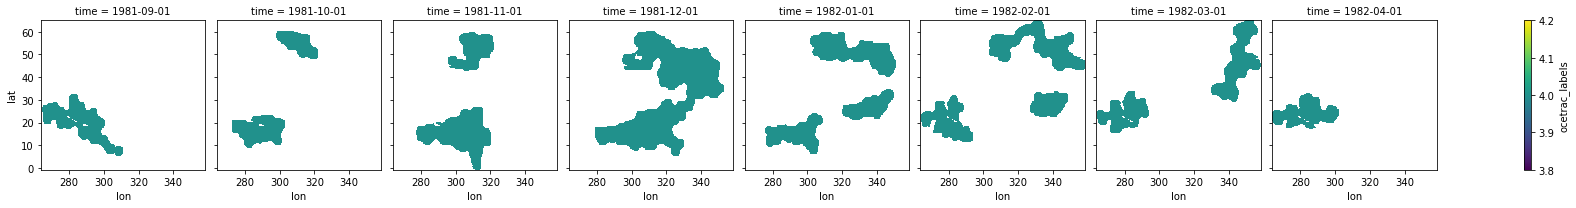

In [270]:
event.plot(col='time', col_wrap=event.shape[0], robust=True);


In [193]:
# Turn this event into a binary image set
binary_event = event.where(event>=0, other=0)
binary_event = binary_event.where(binary_event==0, other=1)

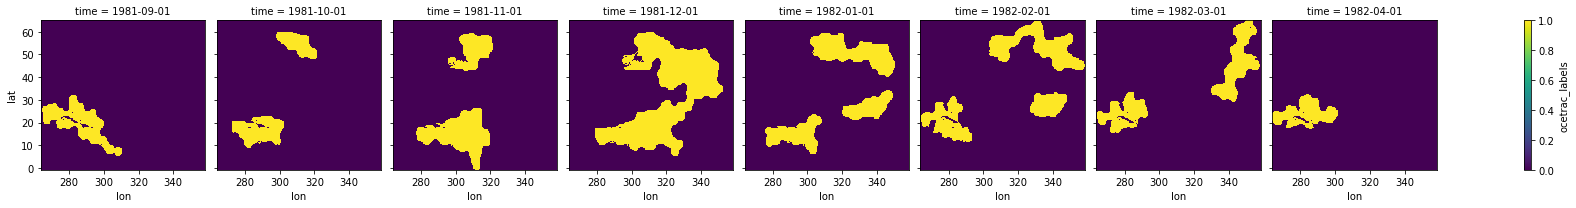

In [194]:
binary_event.plot(col='time', col_wrap=event.shape[0], robust=True);


In [195]:
def get_labels(binary_images):
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels

sub_labels = xr.apply_ufunc(get_labels, binary_event,
                            input_core_dims=[['lat', 'lon']],
                            output_core_dims=[['lat', 'lon']],
                            output_dtypes=[binary_event.dtype],
                            vectorize=True,
                            dask='parallelized')

In [196]:
sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 
    
# The labels are repeated each time step, therefore we relabel them to be consecutive
for i in range(1, sub_labels.shape[0]):
    sub_labels[i,:,:] = sub_labels[i,:,:].values + sub_labels[i-1,:,:].max().values

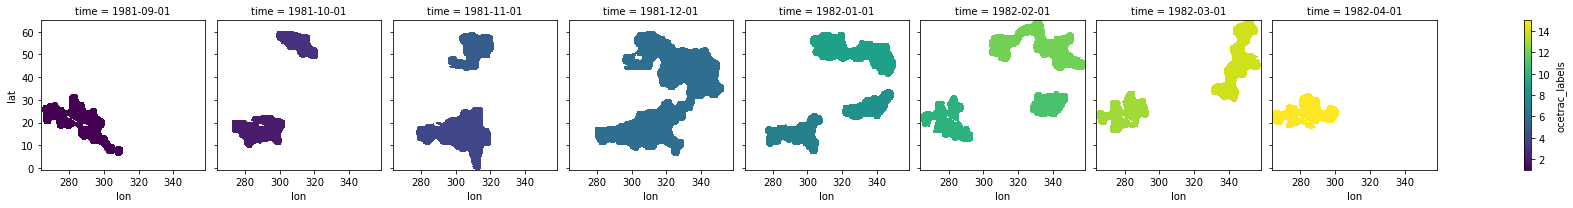

In [197]:
sub_labels.plot(col='time', col_wrap=event.shape[0], robust=True);


In [198]:
def get_centroids(sub_labels):
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

for s in np.arange(0, sub_labels.shape[0]):
    print(f"time {s}")
    mhw['centroid'].append(get_centroids(sub_labels.isel(time=s)))


time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7


In [199]:
mhw['centroid']

[[(20.125, 286.625)],
 [(16.625, 288.375), (54.875, 310.625)],
 [(14.875, 302.875), (51.625, 310.125)],
 [(33.125, 319.375)],
 [(15.125, 293.625), (26.875, 335.625), (51.125, 326.875)],
 [(20.875, 279.875), (28.125, 337.625), (53.625, 331.625)],
 [(24.125, 280.125), (46.625, 345.375)],
 [(24.125, 283.125)]]

*Mean, Max, Min, Cumulative Intensities*

In [200]:
coords = sub_labels.stack(z=('lat','lon')).dropna(dim='z', how='all')

In [201]:
coords

<xarray.DataArray 'ocetrac_labels' (time: 8, z: 41285)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 4.,  4.,  4., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., 14., 14., 14.],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 1982-04-01
  * z        (z) MultiIndex
  - lat      (z) float64 -0.625 -0.625 -0.625 -0.625 ... 64.88 64.88 64.88 64.88
  - lon      (z) float64 311.6 311.9 312.1 312.6 ... 353.4 353.6 353.9 354.1

In [202]:
# Weights for global mean
dlon = np.cos(ds.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(ds.lon)
cell_area = dlon * dlat

weights = np.cos(np.deg2rad(ds.lat))

def get_intensity(event, ssta, cell_area):
    coords = event.stack(z=('lat','lon')).dropna(dim='z', how='all')
    event_ssta = ssta.stack(z=('lat','lon')).where(coords).unstack()
#     event_ssta_weighted = event_ssta.weighted(weights)
    mhw['intensity_mean'].append(event_ssta.mean(('lat','lon')).values)
    mhw['intensity_max'].append(event_ssta.max(('lat','lon')).values) 
    mhw['intensity_min'].append(event_ssta.min(('lat','lon')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coord_pairs = [(coords.isel(time=t[0]).lat.values, 
                  coords.isel(time=t[0]).lon.values) for t in enumerate(event.time)]
    
    mhw['coords'].append(coord_pairs)
    
    return mhw


In [301]:
coords = event.stack(z=('lat','lon'))
coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
                  coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(event.time)]

In [341]:
lat = coord_pairs[0][0]
lon = coord_pairs[0][1]

dlon = np.cos(lat * np.pi/180) *111
dlat = 111 * np.ones(len(lon))
cell_area = dlon * dlat
mhw['area'].append(cell_area.sum())

In [342]:
cell_area

array([12261.67101733, 12261.67101733, 12261.67101733, ...,
       10405.8440116 , 10405.8440116 , 10405.8440116 ])

In [327]:
event_ssta = ds.mhw_ssta_notrend.where(event>0, drop=True)

/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [331]:
mhw = get_intensity_area(event, ds.mhw_ssta_notrend, mhw)

/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [333]:
mhw['area']

[77448836151240.2]

In [58]:
# intensity_image = ds.ocetrac_labels.expand_dims(dim='ssta').transpose('time','lat','lon','ssta')
# intensity_image = xr.concat([intensity_image, ds.mhw_ssta_notrend], dim="ssta")
# props = regionprops(labels.astype('int').values, intensity_image=intensity_image.values)
